In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pylab

from orderedset import OrderedSet

# %pylab inline

In [2]:
#-----------------------Simulating belief updates in a network----------------------------------------------#


class Patch:

    NEUTRAL = 'w'

    def __init__(self, id, status=None, pos=(0, 0)):
        if not status:
            self.status = Patch.NEUTRAL
        else:
            self.status = status
        self.pos = pos
        self.label = 'N'
        self.id = id

    def set_belief(self, belief):
        self.status = belief

    def get_belief(self):
        return self.status

    def set_expert(self):
        self.label = 'E'

    def is_expert(self):
        return self.label == 'E'

    def __str__(self):
        return(str(self.id))

    def __repr__(self):
        return(str(self.id))

    def __hash__(self):
        return hash(self.id)

    def __eq__(self, other):
        if not other:
            return False
        return self.id == other.id


class Belief(object):
    BELIEVE = 'b'
    DISBELIEVE = 'r'
    UNDECIDED = 'y'

    def __init__(self):
        self.believe_patches = set()
        self.disbelieve_patches = set()
        self.undecided_patches = set()

        self.belief_states = [Belief.BELIEVE, Belief.DISBELIEVE, Belief.UNDECIDED]

        self.belief_states_patches = {
            Belief.BELIEVE: self.believe_patches,
            Belief.DISBELIEVE: self.disbelieve_patches,
            Belief.UNDECIDED: self.undecided_patches
        }

    def set_belief(self, patch, state):
        if self.check_state(state):
            patch.set_belief(state)
            for belief_state in self.belief_states:
                if belief_state == state:
                    self.belief_states_patches[state].add(patch)
                elif patch in self.belief_states_patches[belief_state]:
                    self.belief_states_patches[belief_state].remove(patch)

    def get_belief(self, patch):
        for state in self.belief_states:
            if patch in self.belief_states_patches[state]:
                return state

    def check_state(self, state):
        if state not in [Belief.BELIEVE, Belief.DISBELIEVE, Belief.UNDECIDED]:
            return False
        return True


class Simulation(object):
    NR_PATCHES = 100   # Number of patches
    C_DISTANCE = 15  # An arbitrary parameter to determine which patches are connected
    NR_OF_EXPERTS = 1
    EXPERT_BELIEF = Belief.BELIEVE
    # this should be greater than 0.5 so that only one belief state can be above it at a time
    BELIEF_UPDATE_THRESHOLD = 0.6

    # these are used for generating the initial states of the patches
    INIT_BELIEVE_THRESHOLD = 0.6
    INIT_DISBELIEVE_THRESHOLD = 0.3

    # TODO: implement algorithm for generating small-world networks

    def __init__(self, nr_patches=NR_PATCHES,
                 nr_of_experts=NR_OF_EXPERTS,
                 expert_belief=Belief.BELIEVE,
                 belief_update_threshold=BELIEF_UPDATE_THRESHOLD,
                 init_believe_threshold=INIT_BELIEVE_THRESHOLD,
                 init_disbelieve_threshold=INIT_DISBELIEVE_THRESHOLD,
                 c_distance=C_DISTANCE):
        self.nr_patches = nr_patches
        self.nr_of_experts = nr_of_experts
        self.expert_belief = expert_belief
        self.belief_update_threshold = belief_update_threshold
        self.init_believe_threshold = init_believe_threshold
        self.init_disbelieve_threshold = init_disbelieve_threshold
        self.c_distance = c_distance
        self.step = 0
        self.patches = []
        self.history = []
        self.experts = set()

        self.graph = nx.Graph()
        self.generate_patches_2d()

        self.belief = Belief()
        self.set_initial_beliefs()
        self.add_experts()

        self.save_history()

    def set_initial_beliefs(self):
        for patch in self.patches:
            self.set_random_belief(patch)

    def set_random_belief(self, patch):
        belief_random = np.random.uniform()
        if belief_random > self.init_believe_threshold:
            self.belief.set_belief(patch, Belief.BELIEVE)
        elif belief_random > self.init_disbelieve_threshold:
            self.belief.set_belief(patch, Belief.DISBELIEVE)
        else:
            self.belief.set_belief(patch, Belief.UNDECIDED)

    def generate_patches_2d(self):
        # maybe use some Barabasi-Albert graph instead of random generation?
        positions = np.random.uniform(high=100, size=(self.nr_patches, 2))
        # add patches to the graph
        for i in range(self.nr_patches):
            patch = self.generate_patch(id=i, pos=positions[i])
            self.graph.add_node(patch)
            self.patches.append(patch)
        # add edges
        for p1 in self.graph.nodes():
            for p2 in self.graph.nodes():
                if p1 == p2:
                    continue
                if self.distance_2d(p1, p2) <= self.c_distance:
                    self.graph.add_edge(p1, p2)

    def distance_2d(self, p1, p2):
        return np.sqrt((p1.pos[1]-p2.pos[1])**2+(p1.pos[0]-p2.pos[0])**2)

    def generate_patch(self, id, pos):
        return Patch(id=id, pos=pos)

    def add_experts(self):
        for i in range(self.nr_of_experts):
            while True:
                patch = np.random.choice(self.patches)
                if not self.is_expert(patch):
                    patch.set_expert()
                    self.belief.set_belief(patch, self.expert_belief)
                    self.experts.add(patch)
                    break

    def is_expert(self, patch):
        return patch in self.experts

    def save_history(self):
        self.history.append({
            Belief.BELIEVE: len(self.belief.believe_patches),
            Belief.DISBELIEVE: len(self.belief.disbelieve_patches),
            Belief.UNDECIDED: len(self.belief.undecided_patches)})

    def draw_graph(self):
        pylab.figure(1, figsize=(8, 8))
        nx.draw(self.graph, {patch: patch.pos for patch in self.graph.nodes()},
                with_labels=True,
                node_color=[patch.status for patch in self.graph.nodes()])
        pylab.show()

    def draw_history(self):
        time = range(1, len(self.history)+1)
        args = []
        for state in self.belief.belief_states:
            args.append(time)
            args.append([h[state] for h in self.history])
            args.append(state)
        kwargs = {'figure': pylab.figure(2, (8, 8))}
        pylab.plot(*args, **kwargs)

    def run_simulation(self, steps=1):
        for step in range(steps):
            for patch in self.patches:
                self.update_belief(patch)
            self.save_history()

    def update_belief(self, patch):
        belief_state = self.belief.get_belief(patch)

        # if there is expert influence around, adopt the belief of the expert
        expert_influence = self.get_expert_influence(patch)
        if expert_influence:
            self.belief.set_belief(patch, expert_influence)
            return

        # if agent believes or disbelieves something, friends influence that is above the
        # BELIEF_UPDATE_THRESHOLD will make him become undecided
        # if he is undecided, friends influence above the BELIEF_UPDATE_THRESHOLD will make him
        # update his belief to either BELIEVE or DISBELIEVE
        relevant_influence = self.get_influence_above_threshold(patch)
        if belief_state == Belief.UNDECIDED and relevant_influence:
            self.belief.set_belief(patch, relevant_influence)
        elif relevant_influence and belief_state != relevant_influence:
            self.belief.set_belief(patch, Belief.UNDECIDED)

    def get_influence_above_threshold(self, patch):
        friends_influence = self.get_friends_influence(patch)
        for state in [Belief.BELIEVE, Belief.DISBELIEVE]:
            if friends_influence[state] >= self.belief_update_threshold:
                return state
        return None

    def get_expert_influence(self, patch):
        # for now all experts hold the same belief state, but maybe we want to change that in the future
        # so that experts do not all have the same belief state
        for friend in self.graph[patch]:
            if self.is_expert(friend):
                return self.belief.get_belief(friend)

    def get_friends_influence(self, patch):
        influence = {
            Belief.BELIEVE: 0,
            Belief.DISBELIEVE: 0,
        }
        total_friends = len(self.graph[patch])
        if total_friends == 0:  # who can influence him?
            return influence
        for friend in self.graph[patch]:
            state = self.belief.get_belief(friend)
            if state in [Belief.BELIEVE, Belief.DISBELIEVE]:
                influence[state] += 1
        for state in [Belief.BELIEVE, Belief.DISBELIEVE]:
            influence[state] = round(float(influence[state])/float(total_friends), 2)
        return influence
    

/Users/yunqixue/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/yunqixue/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/yunqixue/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/yunqixue/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

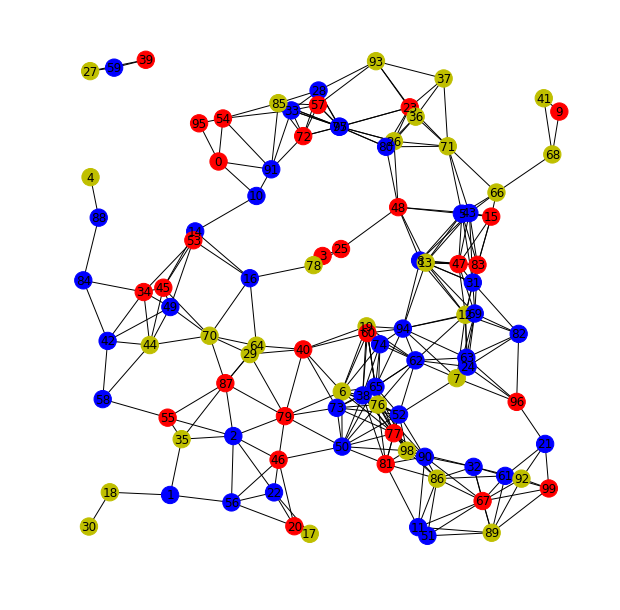

NameError: name 'BELIEVE' is not defined

In [3]:
    simulation = Simulation()
    simulation.draw_graph()
    simulation.run_simulation(30)
    simulation.draw_history()

    Blue = BELIEVE
    Red = UNBELIEVE
    Yellow = UNDECIDED

Questions:
1. Can we know which node is the expert?
2. 